# Kaggle: A SVM & Random Forest Approach
## Titanic: Machine Learning from Disaster

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
pd.options.display.max_rows = 1000

### Reading the Data

In [2]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

## Feature creation
### Creating designation column

In [6]:
def create_designation(dataset):

    new_feature = dataset.Name.str.findall(r'[\w]+\.', re.IGNORECASE)
    new_feature = new_feature.apply(lambda x: x[0], convert_dtype=str)
    cond = new_feature.value_counts().index[:4].values
    new_feature.where(new_feature.isin(cond), other='Other.', inplace=True)

    dataset['Designation'] = new_feature

### Creating a bucket to the Age feature
imputing missing values of age

In [7]:
def create_agebucket(dataset):

    AgeBucket = dataset.Age.fillna(train.Age.median())
    AgeBucket = pd.cut(AgeBucket, [0, 15, 30, 45, 80])
    
    dataset['AgeBucket'] = AgeBucket

### Creating a Has Cabin feature

In [8]:
def has_cabin(dataset):
    dataset['has_cabin'] = dataset.Cabin.notna().astype(np.int64)

### Creating a feature based on the number of relatives onboard

In [9]:
def create_relative(dataset):

    RelativesOnboard = train.SibSp + train.Parch + 1
    RelativesOnboard = pd.cut(RelativesOnboard, [0, 1, 2, 4, 11])
    dataset['RelativesOnboard'] = RelativesOnboard

### Modifying sex feature

In [10]:
def modify_sex(dataset):
    dataset['Sex'] = dataset.Sex.map({'female': 1, 'male': 0})

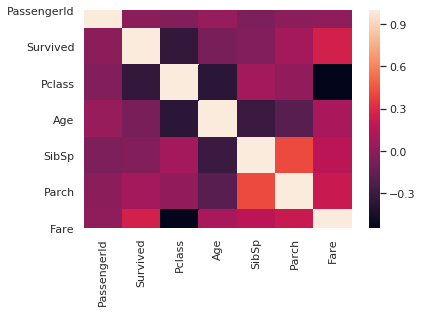

In [11]:
sns.heatmap(train.corr())
plt.show()

## Creating a custom transform function

In [12]:
from sklearn.preprocessing import FunctionTransformer

def add_new_features(X):
    create_designation(X)
    create_agebucket(X)
    create_relative(X)
    modify_sex(X)
    has_cabin(X)
    return X

new_features = FunctionTransformer(add_new_features, validate=False)

In [13]:
from sklearn.preprocessing import LabelBinarizer

class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

### Separating Features from Labels

In [14]:
train_features = train.drop('Survived', axis=1)
train_labels = train['Survived'].copy()

In [16]:
train_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

categorical_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('dummies', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

numerical_attributes = ['Fare', 'Pclass']
categorical_attributes = ['Embarked', 'AgeBucket', 'Designation']
binary_attributes = ['Sex', 'has_cabin']

column_pipeline = ColumnTransformer([
    ('binary', LabelBinarizerPipelineFriendly(), binary_attributes),
    ('numerical', StandardScaler(), numerical_attributes),
    ('categorical', categorical_pipeline, categorical_attributes)
])

full_pipeline = Pipeline([
    ('new_features', new_features),
    ('columns', column_pipeline)
])

train_prepred = full_pipeline.fit_transform(train_features)

## Fine Tuning

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, expon
from sklearn.svm import SVC

parameters = {
    'C' : reciprocal(1, 1000)
}
svm_clf = SVC(gamma='auto', class_weight='balanced')

ran_search = RandomizedSearchCV(svm_clf, param_distributions=parameters, 
                                n_iter=1000, cv=10, scoring='f1_weighted', 
                                verbose=3, n_jobs=4, refit=True)
ran_search.fit(train_prepred, train_labels)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 206 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 654 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done 1550 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done 2702 tasks      | elapsed:   53.7s
[Parallel(n_jobs=4)]: Done 4110 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 5774 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 7694 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 9870 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 10000 out of 10000 | elapsed:  3.1min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto', kernel='rbf',
                                 max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=1000, n_jobs=4,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff430ca9780>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1_weighted', verbose=3)

In [39]:
ran_search.best_score_

0.8169543358066755

In [40]:
ran_search.best_params_

{'C': 767.066131919603}

In [42]:
import joblib

In [43]:
joblib.dump(ran_search.best_estimator_, 'optimised_svm.plk')

['optimised_svm.plk']

In [44]:
optimised_svm = joblib.load('optimised_svm.plk')

In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(optimised_svm, train_prepred, train_labels, 
                         scoring='roc_auc', cv=8)
scores

array([0.82440175, 0.84226491, 0.85473542, 0.87681159, 0.83923155,
       0.80984952, 0.83595938, 0.91509104])

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [5, 10, 25]
min_samples_leaf = [4, 10, 20]
bootstrap = [True, False]

random_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

forest_clf = RandomForestClassifier()
search_forest = RandomizedSearchCV(forest_clf, param_distributions=random_param, cv=5,
                                  n_iter=100, verbose=5, n_jobs=-1, scoring='f1_weighted')
search_forest.fit(train_prepred, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [5, 10, 25], 'min_samples_leaf': [4, 10, 20], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose

In [25]:
search_forest.best_params_

{'n_estimators': 1200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': False}

In [26]:
search_forest.best_score_

0.8800284120886611

In [27]:
joblib.dump(search_forest.best_estimator_, 'optimised_forest.plk')

['optimised_forest.plk']

In [19]:
optimised_forest = joblib.load('optimised_forest.plk')

In [20]:
from sklearn.model_selection import cross_val_predict

In [21]:
optimised_svm_decisions = cross_val_predict(optimised_svm, train_prepred, train_labels, 
                                         cv=8, method='decision_function')
optimised_forest_decisions = cross_val_predict(optimised_forest, train_prepred, train_labels, 
                                         cv=8, method='predict_proba')

In [22]:
optimised_forest_decisions = optimised_forest_decisions[:, 1] # score = proba of positive class

## The ROC Curve

In [23]:
from sklearn.metrics import roc_curve

In [24]:
svm_fpr, svm_tpr, _ = roc_curve(train_labels, optimised_svm_decisions)
forest_fpr, forest_tpr, _ = roc_curve(train_labels, optimised_forest_decisions)

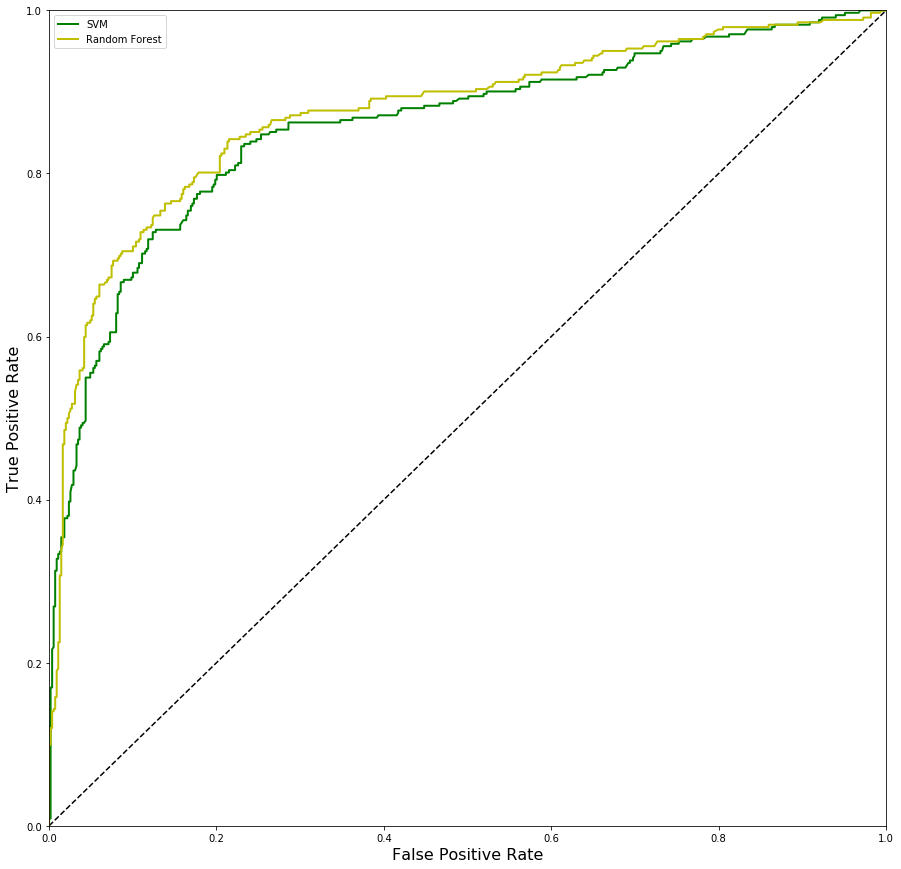

In [25]:
plt.figure(figsize=(15, 15))

plt.plot([0, 1], [0, 1], 'k--')

plt.plot(svm_fpr, svm_tpr, 'g', lw=2, label='SVM')
plt.plot(forest_fpr, forest_tpr, 'y', lw=2, label='Random Forest')

plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)

plt.legend()

plt.show()

In [26]:
from sklearn.metrics import roc_auc_score

#### SVM Score

In [27]:
roc_auc_score(train_labels, optimised_svm_decisions)

0.8578835522321285

#### Random Forest Score

In [28]:
roc_auc_score(train_labels, optimised_forest_decisions)

0.8735553212113465

## BoxPlot

In [29]:
svm_scores = cross_val_score(optimised_svm, train_prepred, train_labels, cv=10)
forest_scores = cross_val_score(optimised_forest, train_prepred, train_labels, cv=10)

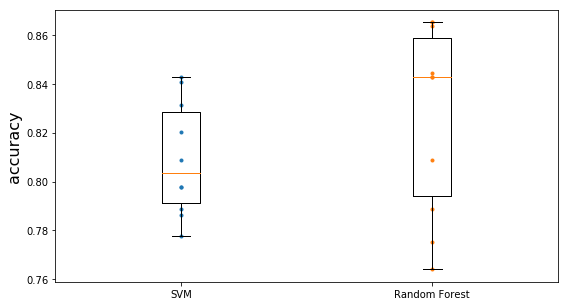

In [30]:
plt.figure(figsize=(9, 5))

#creating the dots
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, '.')

# creating the boxplot
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))
plt.ylabel('accuracy', fontsize=16)

plt.show()

# Neural Networks

In [47]:
import tensorflow as tf
tf.__version__

'2.0.0-dev20190712'

In [85]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', 
                          input_shape=[train_prepred.shape[1]]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [86]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

In [87]:
model.fit(train_prepred, train_labels, 
          batch_size=32, 
          epochs=50,
          shuffle=True,
          verbose=2,
          use_multiprocessing=True)

Train on 891 samples
Epoch 1/50
891/891 - 0s - loss: 0.5614 - accuracy: 0.7531
Epoch 2/50
891/891 - 0s - loss: 0.4488 - accuracy: 0.7957
Epoch 3/50
891/891 - 0s - loss: 0.4256 - accuracy: 0.8047
Epoch 4/50
891/891 - 0s - loss: 0.4136 - accuracy: 0.8182
Epoch 5/50
891/891 - 0s - loss: 0.4067 - accuracy: 0.8272
Epoch 6/50
891/891 - 0s - loss: 0.4001 - accuracy: 0.8294
Epoch 7/50
891/891 - 0s - loss: 0.3957 - accuracy: 0.8238
Epoch 8/50
891/891 - 0s - loss: 0.3931 - accuracy: 0.8384
Epoch 9/50
891/891 - 0s - loss: 0.3895 - accuracy: 0.8384
Epoch 10/50
891/891 - 0s - loss: 0.3828 - accuracy: 0.8418
Epoch 11/50
891/891 - 0s - loss: 0.3834 - accuracy: 0.8418
Epoch 12/50
891/891 - 0s - loss: 0.3785 - accuracy: 0.8429
Epoch 13/50
891/891 - 0s - loss: 0.3748 - accuracy: 0.8440
Epoch 14/50
891/891 - 0s - loss: 0.3751 - accuracy: 0.8373
Epoch 15/50
891/891 - 0s - loss: 0.3762 - accuracy: 0.8395
Epoch 16/50
891/891 - 0s - loss: 0.3685 - accuracy: 0.8485
Epoch 17/50
891/891 - 0s - loss: 0.3710 - ac

## Transform the Test Set

In [71]:
test_prepared = full_pipeline.transform(test)

In [50]:
# missing values
index = np.isnan(test_prepared[:, 2])
test_prepared[index, 2] = np.nanmedian(test_prepared[:, 2])

## Creating a CSV Output 

In [88]:
def save(classifier):
    submission = pd.DataFrame()
    submission['PassengerId'] = test.PassengerId
    submission['Survived'] = classifier.predict_classes(test_prepared)
    return submission

In [52]:
svm = save(optimised_svm)
forest = save(optimised_forest)

In [89]:
dnn = save(model)

/home/joao/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/sequential.py:328: RuntimeWarning: invalid value encountered in greater
  return (proba > 0.5).astype('int32')


In [91]:
dnn.to_csv('submission_dnn.csv', index=False)

In [53]:
# index=False get rif of indexes in our file
svm.to_csv('submission_svm.csv', index=False)
forest.to_csv('submission_forest.csv', index=False)